## 6. The Impact of Learning Rate Annealing

So far, we have initialized a learning rate, and it has remained the same across all the epochs while training the model. This calls for having a high learning rate initially and gradually lowering it later on as the model achieves near-optimal accuracy. This can be done by monitoring validation loss and if the validation loss does not decrease (let's say, over the previous x epochs), then we reduce the learning rate.

In [15]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [16]:
from torchvision import datasets
data_folder = "Datasets"

In [17]:
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
train_images = fmnist.data                                
train_targets = fmnist.targets

In [18]:
validation_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
validation_images = validation_fmnist.data                                
validation_targets = validation_fmnist.targets 

In [19]:
from common_functions import get_data,build_model,display_train_validation_results, train_batch, get_accuracy, get_validation_loss_value

In [20]:
train_data_loader, validation_data_loader = get_data(32,train_images,train_targets,validation_images,validation_targets)

In [21]:
model,loss_function, optimizer = build_model(optimizer = Adam , lr=1e-2)

In [22]:
from torch.optim import lr_scheduler

In [23]:
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,                                  #reduce learning rate parameter of optimizer
    factor=0.5 ,                                # by a factor of 0.5 
    patience=0 , 
    threshold=0.01,                            # if a certain value (validation loss) does not improve by this threshold value
    verbose=True , 
    min_lr=1e-5 ,                               #learning rate can not be below 1e-5
    threshold_mode='abs')

In [24]:
def train_with_validation(epoch_number,train_data_loader,validation_data_loader,model,loss_function,optimizer):
    train_losses, train_accuracies = [], []   
    validation_losses, validation_accuracies = [], [] 
    for epoch in range (epoch_number):               
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       

        for batch in (iter(train_data_loader)):      
            input_batch, targets = batch                     
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  

            batch_losses.append(batch_loss)                               
        epoch_loss = np.array(batch_losses).mean()                        
        train_losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        train_accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        
        for batch in (iter(validation_data_loader)):
            input_batch, targets = batch
            validation_loss_value = get_validation_loss_value(input_batch, targets, model, loss_function)
            validation_accuracy = get_accuracy(input_batch, targets, model)
            scheduler.step(validation_loss_value)  #the scheduler should be activated 
                                                   #whenever the validation loss does not decrease over consecutive epochs.
            
            
        validation_losses.append(validation_loss_value)
        print(f"Validation Loss: {validation_loss_value:0.3f}")
        valiation_epoch_accuracy = np.mean(validation_accuracy)
        print(f"Validation Accuracy: {valiation_epoch_accuracy*100:0.0f}%")
        validation_accuracies.append(valiation_epoch_accuracy)
        print('<--------------------------------------------------------->')
        
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [25]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(50, train_data_loader,
                                                                                                 validation_data_loader,
                                                                                                 model,
                                                                                                 loss_function,
                                                                                                 optimizer)

Epoch: 1
Train Loss: 0.536
Train Accuracy: 85%
Validation Loss: 0.455
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.433
Train Accuracy: 86%
Validation Loss: 0.442
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.415
Train Accuracy: 85%
Epoch 00003: reducing learning rate of group 0 to 5.0000e-03.
Validation Loss: 0.484
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.357
Train Accuracy: 88%
Validation Loss: 0.403
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.347
Train Accuracy: 87%
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.
Validation Loss: 0.417
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.316
Train Accuracy: 89%
Validation Loss: 0.383
Validation Accuracy: 86%
<-----

Train Loss: 0.270
Train Accuracy: 90%
Validation Loss: 0.370
Validation Accuracy: 87%
<--------------------------------------------------------->


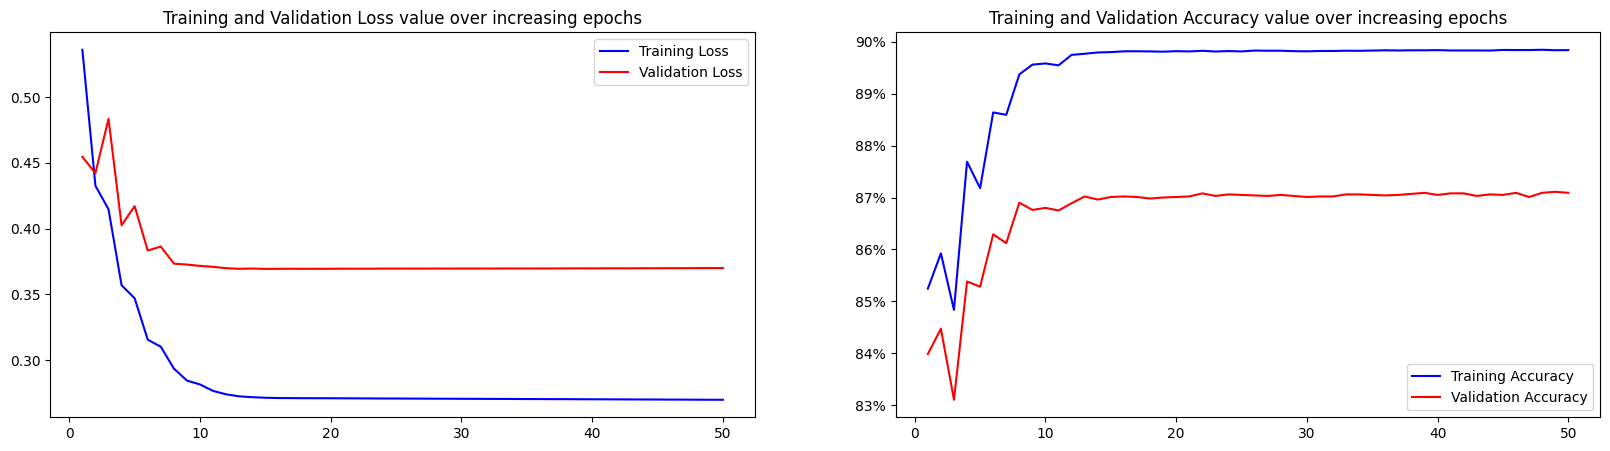

In [26]:
display_train_validation_results(50,train_losses, train_accuracies, validation_losses, validation_accuracies)